In [11]:
import numpy as np
from function import *
import matplotlib.pyplot as plt
from itertools import product

speed_uav =30
speed_ugv =10
survey_time = 1/6
waypoints = [(12, 50), (17, 50), (20, 49),(20, 46)]
plan_output = "0 -> 1 -> 2 -> 3 -> 0"
radii = [2]
ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
ordered_points.append(ordered_points[0])

In [2]:
def compute_ordered_points(plan_output, waypoints):
    ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
    ordered_points.append(ordered_points[0])
    return ordered_points

def initialize_plot(ordered_points):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(*zip(*ordered_points))
    return fig, ax

def compute_paths_for_radius(ordered_points, radius_combination, speed_ugv, speed_uav, survey_time):
    UGV_outer_path = [ordered_points[0]]
    UGV_path = [ordered_points[0]]
    UAV_path = []
    # UAV_distances = []
    UGV_inter_distances = []
    
    # Main logic to compute paths based on radius_combination
    # This is a placeholder for now. We'll populate this in the next steps.
    
    return UGV_path, UAV_path, UGV_outer_path, UGV_inter_distances

def visualize_paths(ax, ordered_points, UGV_path, UAV_path, UGV_outer_path):
    # Placeholder for visualization logic. We'll populate this in the next steps.
    pass

def compute_non_overlapping_pairwise_distances(path):
    """Compute the distances between each non-overlapping pair of points in the given path."""
    return [compute_distance(path[i], path[i+1]) for i in range(0, len(path) - 1, 2)]
    
def compute_tripwise_distances(path):
    """Compute the distances for each set of three points in the given path."""
    distances = []
    for i in range(0, len(path) - 2, 3):
        distance_trip = compute_distance(path[i], path[i+1]) + compute_distance(path[i+1], path[i+2])
        distances.append(distance_trip)
    return distances

def circles_overlap(center1, radius1, center2, radius2):
    """Check if two circles overlap."""
    distance_between_centers = compute_distance(center1, center2)
    return distance_between_centers < (radius1 + radius2)

In [3]:
def find_meeting_point_with_survey_final_updated(center, radius, ugv_start, ugv_end, speed_ugv, speed_uav, survey_time):
    chord_length = np.sqrt((ugv_end[0] - ugv_start[0])**2 + (ugv_end[1] - ugv_start[1])**2)
    
    # If chord_length is zero, return the ugv_start as the meeting point
    if chord_length == 0:
        return ugv_start, 0

    distance_ugv_traveled = speed_ugv * ((radius / speed_uav) + survey_time)
    remaining_distance = chord_length - distance_ugv_traveled
    time_to_meet = remaining_distance / (speed_uav + speed_ugv)
    total_distance_ugv = distance_ugv_traveled + speed_ugv * time_to_meet
    x_meeting = ugv_start[0] + (total_distance_ugv / chord_length) * (ugv_end[0] - ugv_start[0])
    y_meeting = ugv_start[1] + (total_distance_ugv / chord_length) * (ugv_end[1] - ugv_start[1])
    distance_from_center = np.sqrt((x_meeting - center[0])**2 + (y_meeting - center[1])**2)
    wait_time = 0
    if distance_from_center > radius:
        x_meeting, y_meeting = ugv_end[0], ugv_end[1]
        distance_ugv_traveled = chord_length
        time_ugv = distance_ugv_traveled / speed_ugv
        distance_uav_traveled = radius*2
        time_uav = (distance_uav_traveled / speed_uav) + survey_time
        wait_time = time_uav - time_ugv
    return (x_meeting, y_meeting), wait_time

In [4]:
def compute_optimized_paths_for_radius_updated_v2(ordered_points, radius_combination, speed_ugv, speed_uav, survey_time):
    UGV_outer_path = [ordered_points[0]]
    UGV_path = [ordered_points[0]]
    UAV_path = []
    UGVD_inter_without_drone = []
    UGVD_inter_with_drone = []
    chord_end = None
    
    prev_chord_end = None
    
    for i, point in enumerate(ordered_points[:-1]):
        current_radius = radius_combination[i % len(radius_combination)]
        
        # Exclude the start and end points from circles
        if 0 < i < len(ordered_points) - 2:
            angle = angle_between_points(ordered_points[i-1], ordered_points[i])
            nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
            chord_start = point_on_circle(ordered_points[i], angle - np.pi, current_radius)
            chord_end = point_on_circle(ordered_points[i], nextangle, current_radius)
            
            if prev_chord_end and i > 1 and circles_overlap(ordered_points[i], current_radius, ordered_points[i-1], radius_combination[(i-1) % len(radius_combination)]):
                chord_start = prev_chord_end
                print("Checked",chord_start)
            
            final_meeting_point, final_wait_time = find_meeting_point_with_survey_final_updated(
                ordered_points[i], current_radius, chord_start, chord_end, 
                speed_ugv, speed_uav, survey_time
            )
            
            UGVD_inter_without_drone.append(compute_distance(chord_start,final_meeting_point))
            UGVD_inter_with_drone.append(compute_distance(final_meeting_point,chord_end))
            
            UGV_outer_path.append(chord_start)
            
            UAV_path.extend([chord_start, ordered_points[i], final_meeting_point])
            print(UAV_path)
            UGV_path.append(final_meeting_point)
            
            if i > 0 and chord_end:
                UGV_outer_path.append(chord_end)
                
            prev_chord_end = chord_end
    
    if chord_end:
        UGV_outer_path.append(ordered_points[-1])
    UGV_path.append(ordered_points[-1])
    print("UAV_path:",UAV_path)
    return UGV_path, UAV_path, UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone




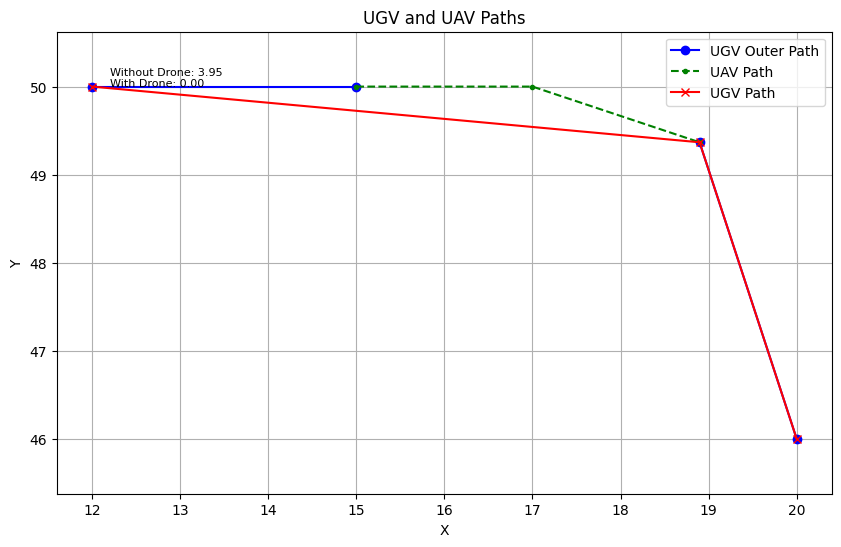

In [12]:
import matplotlib.pyplot as plt

def plot_generated_paths(UGV_path, UAV_path, UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot UGV Outer Path
    for i in range(0, len(UGV_outer_path), 2):
        ax.plot(*zip(*UGV_outer_path[i:i+2]), color='b', linestyle='-', marker='o', label="UGV Outer Path" if i == 0 else "")
    
    # Plot UAV Path (grouped by 3)
    for i in range(0, len(UAV_path), 3):
        ax.plot(*zip(*UAV_path[i:i+3]), color='g', linestyle='--', marker='.', label="UAV Path" if i == 0 else "")
    
    # Plot UGV Inner Path
    ax.plot(*zip(*UGV_path), color='r', linestyle='-', marker='x', label="UGV Path")
    
    # Annotate with distances
    for i in range(len(UGVD_inter_without_drone)):
        text = f"Without Drone: {UGVD_inter_without_drone[i]:.2f}\nWith Drone: {UGVD_inter_with_drone[i]:.2f}"
        ax.annotate(text, (UGV_path[i][0] + 0.2, UGV_path[i][1]), fontsize=8)
    
    # Setting the legend and other plot details
    ax.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('UGV and UAV Paths')
    plt.grid()
    plt.axis('equal')
    plt.show()

# Plotting the paths
plot_generated_paths(UGV_path_updated_v2, UAV_path_updated_v2, UGV_outer_path_updated_v2, UGVD_inter_without_drone_updated_v2, UGVD_inter_with_drone_updated_v2)


In [16]:
def visualize_paths(ax, ordered_points, UGV_path, UAV_path, UGV_outer_path, radius_combination):
    for i, point in enumerate(ordered_points[:-1]):
        ax.annotate(i, (point[0] + 0.5, point[1] + 0.5))
        
        if 0 < i < len(ordered_points) - 2:
            # Extract required details for plotting
            current_radius = radius_combination[i % len(radius_combination)]
            angle = angle_between_points(ordered_points[i-1], ordered_points[i])
            nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
            chord_start = point_on_circle(ordered_points[i], angle - np.pi, current_radius)
            chord_end = point_on_circle(ordered_points[i], nextangle, current_radius)
            final_meeting_point = UAV_path[3*i-1]  # Using the UAV path to get the meeting point
            
            # Plotting details
            draw_circle(ax, ordered_points[i], current_radius)
            plt.scatter(point[0],point[1], color='g', label='Interest Point (Half-way for UAV)')
            plt.scatter(chord_start[0],chord_start[1], color='r', label='Takeoff Point (UGV & UAV split)')
            ax.plot([final_meeting_point[0],chord_end[0] ], [final_meeting_point[1], chord_end[1]], 
                    'm-',label='Path of UGV with Drone')
            ax.plot([chord_start[0], point[0], final_meeting_point[0]], 
                    [chord_start[1], point[1], final_meeting_point[1]], 
                    color='g', linestyle='--', label='Path of UAV')
            ax.plot([chord_start[0], final_meeting_point[0]], 
                    [chord_start[1], final_meeting_point[1]], 
                    color='r', linestyle='-', label='Path of UGV without Drone')
            plt.scatter(final_meeting_point[0], final_meeting_point[1], 
                        color='y', marker='X', s=100, label='Meeting Point')

    # Plot each pair of points in the UGV_outer_path list
    for i in range(0, len(UGV_outer_path), 2):
        ax.plot(*zip(*UGV_outer_path[i:i+2]), color='b', linestyle='-', marker='o')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'TSP Solution, radii = {radius_combination}')
    plt.grid()
    plt.axis('equal')

[(15.0, 50.0), (17, 50), (18.897366596101026, 49.367544467966326)]
UAV_path: [(15.0, 50.0), (17, 50), (18.897366596101026, 49.367544467966326)]


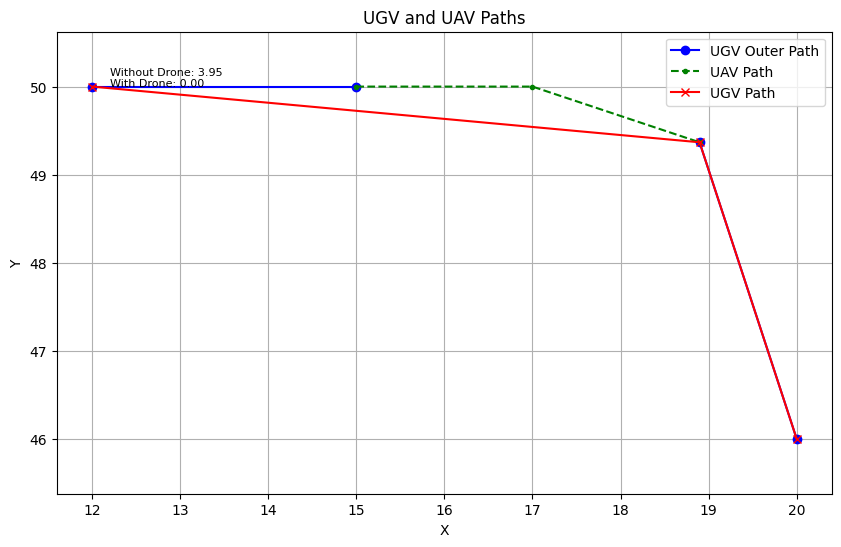

In [6]:
UGV_path_updated_v2, UAV_path_updated_v2, UGV_outer_path_updated_v2, UGVD_inter_without_drone_updated_v2, UGVD_inter_with_drone_updated_v2 = compute_optimized_paths_for_radius_updated_v2(
    waypoints, radii, 10, 20, 5)

# Plotting the paths
plot_generated_paths(UGV_path_updated_v2, UAV_path_updated_v2, UGV_outer_path_updated_v2, UGVD_inter_without_drone_updated_v2, UGVD_inter_with_drone_updated_v2)

IndexError: list index out of range

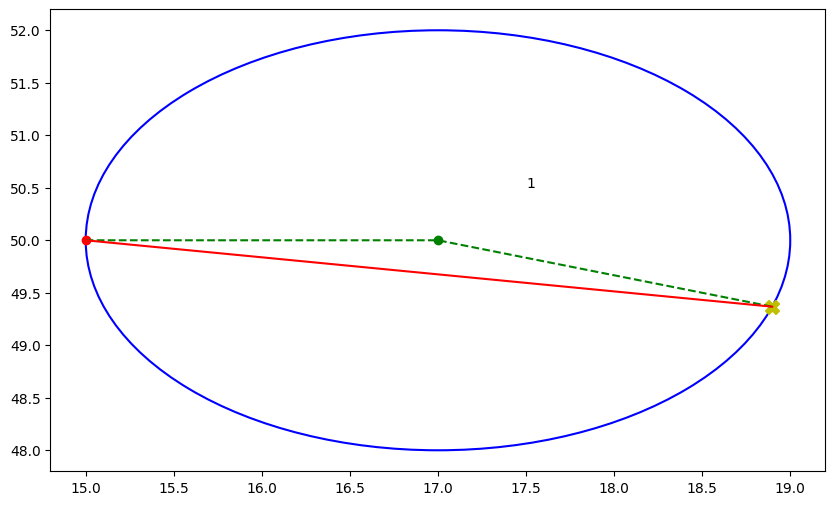

In [13]:
def visualize_paths_updated(ax, ordered_points, UGV_path, UAV_path, UGV_outer_path, radius_combination):
    for i, point in enumerate(ordered_points[:-1]):
        ax.annotate(i, (point[0] + 0.5, point[1] + 0.5))
        
        if 0 < i < len(ordered_points) -2:
            # Extract required details for plotting
            current_radius = radius_combination[i % len(radius_combination)]
            angle = angle_between_points(ordered_points[i-1], ordered_points[i])
            nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
            chord_start = point_on_circle(ordered_points[i], angle - np.pi, current_radius)
            chord_end = point_on_circle(ordered_points[i], nextangle, current_radius)
            final_meeting_point = UAV_path[3*i-1]  # Using the UAV path to get the meeting point
            
            # Plotting details
            draw_circle(ax, ordered_points[i], current_radius)
            plt.scatter(point[0], point[1], color='g', label='Interest Point (Half-way for UAV)')
            plt.scatter(chord_start[0], chord_start[1], color='r', label='Takeoff Point (UGV & UAV split)')
            
            ax.plot([final_meeting_point[0], chord_end[0]], [final_meeting_point[1], chord_end[1]], 
                    'm-', label='Path of UGV with Drone')
            ax.plot([chord_start[0], point[0], final_meeting_point[0]], 
                    [chord_start[1], point[1], final_meeting_point[1]], 
                    color='g', linestyle='--', label='Path of UAV')
            ax.plot([chord_start[0], final_meeting_point[0]], 
                    [chord_start[1], final_meeting_point[1]], 
                    color='r', linestyle='-', label='Path of UGV without Drone')
            plt.scatter(final_meeting_point[0], final_meeting_point[1], 
                        color='y', marker='X', s=100, label='Meeting Point')

    # Plot each pair of points in the UGV_outer_path list
    for i in range(0, len(UGV_outer_path), 2):
        ax.plot(*zip(*UGV_outer_path[i:i+2]), color='b', linestyle='-', marker='o')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'TSP Solution, radii = {radius_combination}')
    plt.grid()
    plt.axis('equal')

# Visualize the paths again using the updated function
fig, ax = plt.subplots(figsize=(10, 6))
visualize_paths_updated(ax, ordered_points, UGV_path_updated_v2, UAV_path_updated_v2, UGV_outer_path_updated_v2, radii)
plt.legend(loc="upper left")
plt.show()


In [14]:
from itertools import product

def plot_solution_final_refined_v2(waypoints, plan_output, radii, speed_ugv, speed_uav, survey_time, plot_graph=True):
    UGVdistances = []
    UAV_total_distances = []
    UGV_outer_path_distances = []
    
    ordered_points = compute_ordered_points(plan_output, waypoints)
    
    for radius_combination in product(radii, repeat=len(waypoints)-1):
        
        if plot_graph:
            fig, ax = initialize_plot(ordered_points)
            
        UGV_path, UAV_path, UGV_outer_path, UGVD_inter_without_drone,UGVD_inter_with_drone = compute_optimized_paths_for_radius_updated_v2(
            ordered_points, radius_combination, speed_ugv, speed_uav, survey_time)
        
        if plot_graph:
            visualize_paths(ax, ordered_points, UGV_path, UAV_path, UGV_outer_path, radius_combination)
            plt.show()
        
        # Calculating the UGV_outer_path distance
        UGV_outer_distance = compute_non_overlapping_pairwise_distances(UGV_outer_path)
        UGV_outer_path_distances.append(format_list_to_decimal(UGV_outer_distance))
        
        if plot_graph:
            UGV_distance = sum(np.linalg.norm(np.array(UGV_path[i]) - np.array(UGV_path[i+1])) 
                               for i in range(len(UGV_path) - 1))
            UGVdistances.append(UGV_distance)
            
            # print(f"UGV Outer Path Distance: {UGV_outer_distance:.2f}")
        UAV_distances_set = format_list_to_decimal(compute_tripwise_distances(UAV_path))

    return  UGVD_inter_without_drone,UGVD_inter_with_drone, UAV_distances_set, UGV_outer_path_distances


[(15.0, 50.0), (17, 50), (17.701744699890877, 49.56156719172939)]
Checked (18.897366596101026, 49.367544467966326)
[(15.0, 50.0), (17, 50), (17.701744699890877, 49.56156719172939), (18.897366596101026, 49.367544467966326), (20, 49), (19.911852407539282, 47.18926811409574)]
Checked (20.0, 47.0)
[(15.0, 50.0), (17, 50), (17.701744699890877, 49.56156719172939), (18.897366596101026, 49.367544467966326), (20, 49), (19.911852407539282, 47.18926811409574), (20.0, 47.0), (20, 46), (18.211145618000167, 46.89442719099991)]
UAV_path: [(15.0, 50.0), (17, 50), (17.701744699890877, 49.56156719172939), (18.897366596101026, 49.367544467966326), (20, 49), (19.911852407539282, 47.18926811409574), (20.0, 47.0), (20, 46), (18.211145618000167, 46.89442719099991)]


TypeError: visualize_paths() takes 5 positional arguments but 6 were given

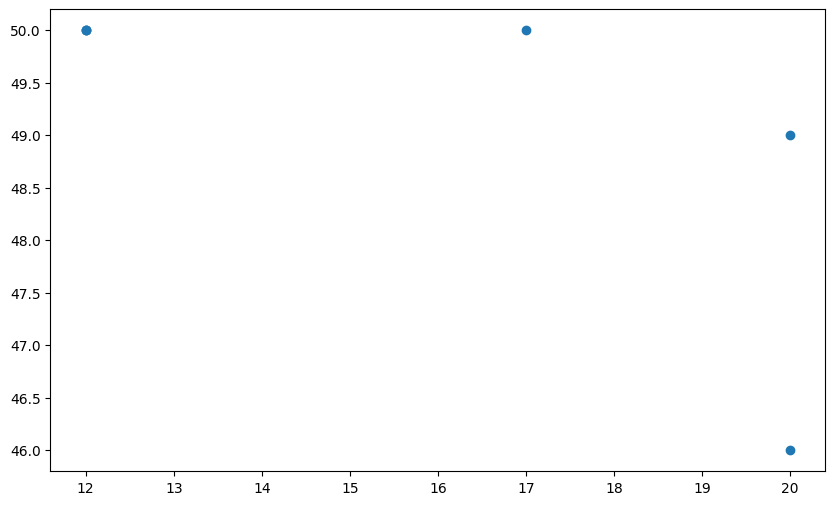

In [15]:
# Sample run again
UGVD_inter_without_drone,UGVD_inter_with_drone, UAV_distances_set, UGV_outer_path_distances= plot_solution_final_refined_v2(waypoints, plan_output, radii, speed_ugv, speed_uav, survey_time, plot_graph=True)
